In [86]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
import seaborn as sns

dye_df = pd.read_csv('Data/fp_dye.csv', index_col=0)
activity_df = pd.read_csv('Data/fp_activity.csv', index_col=0)

In [87]:
dye_df.shape

(2007, 2)

In [88]:
activity_df.head()

,VOC,JSC,FF,PCE
0,687.0,10.79,0.70,5.19
7,678.0,13.20,0.67,6.00
8,695.0,12.20,0.74,6.20
9,800.0,9.00,0.76,5.50
10,560.0,3.41,0.73,1.39


,Molecule SMILE,Molecule keywords,ROMol
0,N#C/C(=C\c1ccc(cc1)N(c1ccccc1)CCCCCCN1c2ccccc2...,phenothiazine,
7,N#C/C(=C\c1ccc(s1)c1ccc(s1)c1ccc(cc1)N(c1ccc(c...,"coumarin, triphenylamine",
8,N#C/C(=C\c1ccc(s1)c1ccc(cc1)N(c1ccc(cc1)/C=C/c...,"coumarin, triphenylamine",
9,CCN(c1ccc2c(c1)oc(=O)c(c2)/C=C/c1ccc(cc1)N(c1c...,"coumarin, triphenylamine",
10,CCN([C@@H]1C=Cc2c(C1)oc(=O)c(c2)c1ccc(cc1)c1cc...,coumarin,

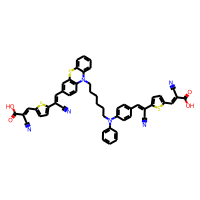
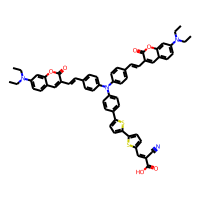
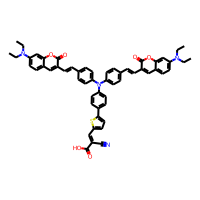
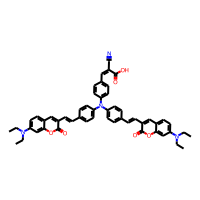
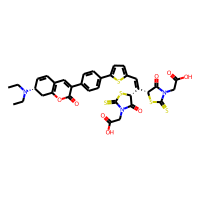

In [89]:
# add molecule column to dye dataframe

PandasTools.AddMoleculeColumnToFrame(dye_df, smilesCol='Molecule SMILE')

dye_df.head()

In [90]:
radius = 3
nBits = 1024

ECFP6 = [AllChem.GetMorganFingerprintAsBitVect(x, radius=radius, nBits=nBits) for x in dye_df['ROMol']]

In [91]:
ecfp6_name = [f'Bit_{i}' for i in range(nBits)]
ecfp6_bits = [list(l) for l in ECFP6]

dye_morgan_df = pd.DataFrame(ecfp6_bits, index=dye_df.index, columns=ecfp6_name)

In [92]:
dye_morgan_df.to_csv('Data/dye_ecfp6.csv')

In [93]:
X_train, X_test, Y_train, Y_test = train_test_split(pd.concat([dye_morgan_df, dye_df['Molecule keywords']], axis=1 ), activity_df['PCE'], test_size=0.2)

print(X_train.shape)

reg = RandomForestRegressor()
reg.fit(X_train.drop(['Molecule keywords'], axis=1), Y_train)

pred_train_PCE = reg.predict(X_train.drop(['Molecule keywords'], axis=1))
pred_test_PCE = reg.predict(X_test.drop(['Molecule keywords'], axis=1))

r2 = r2_score(Y_train, pred_train_PCE)
q2 = r2_score(Y_test, pred_test_PCE)

print(f'R2: {r2}, Q2: {q2}')

train_results_dict = {'True': Y_train, 'Predicted': pred_train_PCE}
test_results_dict = {'True': Y_test, 'Predicted': pred_test_PCE}

train_results_df = pd.concat([pd.DataFrame.from_dict(train_results_dict), X_train['Molecule keywords']], axis=1)
test_results_df = pd.concat([pd.DataFrame.from_dict(test_results_dict), X_test['Molecule keywords']], axis=1)

(1605, 1025)
R2: 0.9353457904917938, Q2: 0.4874976396348071


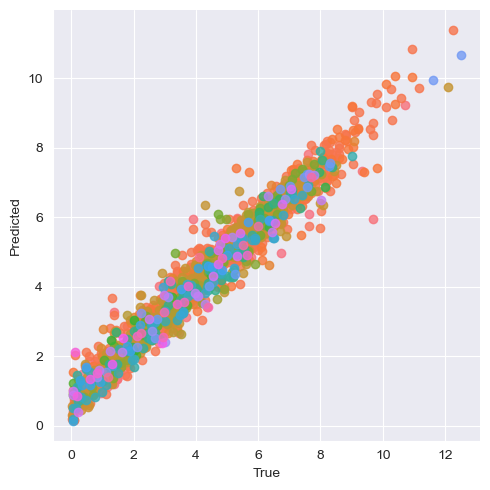

In [94]:
sns.lmplot(train_results_df, x='True', y='Predicted', hue='Molecule keywords', legend=False, fit_reg=False)


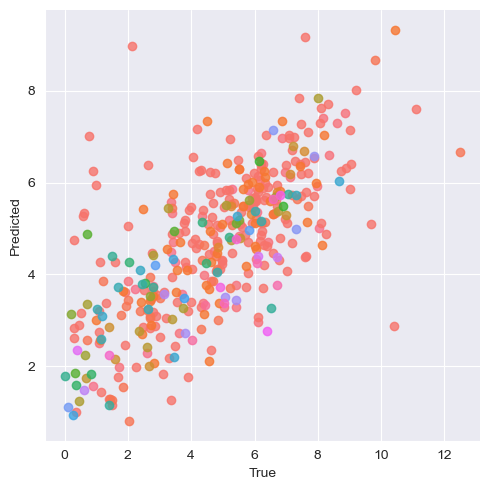

In [95]:
sns.lmplot(test_results_df, x='True', y='Predicted', hue='Molecule keywords', legend=False, fit_reg=False)

In [96]:
X_test

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,Molecule keywords
3240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,coumarin
3010,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,indoline
2624,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,triphenylamine
1579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,triphenylamine
756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,carbazole
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,triphenylamine
230,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,phenothiazine
194,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,carbazole
1238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,anthracene


In [97]:
# dye fingerprint + molecule keywords
dye_family = pd.concat([dye_morgan_df, dye_df['Molecule keywords']], axis=1 )

transformer = make_column_transformer((OneHotEncoder(sparse=False), ['Molecule keywords']), remainder='passthrough')

transformed = transformer.fit_transform(dye_family)

dye_family_fp_df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [98]:
dye_family_fp_df.to_csv('Data/dye_ecfp6_family_oneHot.csv')

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(dye_family_fp_df, activity_df['PCE'], test_size=0.2)

print(X_train.shape)

reg = RandomForestRegressor()
reg.fit(X_train, Y_train)

pred_train_PCE = reg.predict(X_train)
pred_test_PCE = reg.predict(X_test)

r2 = r2_score(Y_train, pred_train_PCE)
q2 = r2_score(Y_test, pred_test_PCE)

print(f'R2: {r2}, Q2: {q2}')

train_results_dict = {'True': Y_train, 'Predicted': pred_train_PCE}
test_results_dict = {'True': Y_test, 'Predicted': pred_test_PCE}

train_results_df = pd.DataFrame.from_dict(train_results_dict)
test_results_df = pd.DataFrame.from_dict(test_results_dict)

(1605, 1146)
R2: 0.9337440454671959, Q2: 0.5478327364202915


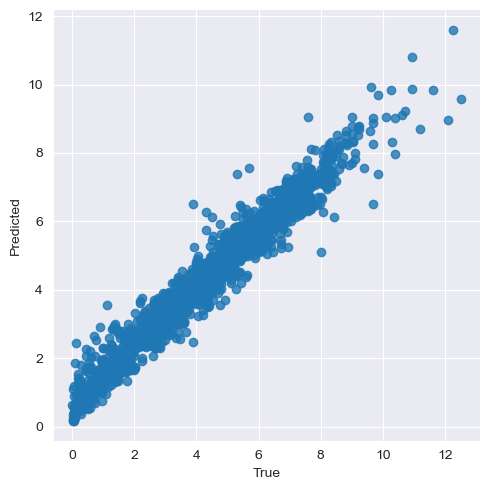

In [102]:
sns.lmplot(train_results_df, x='True', y='Predicted', legend=False, fit_reg=False)

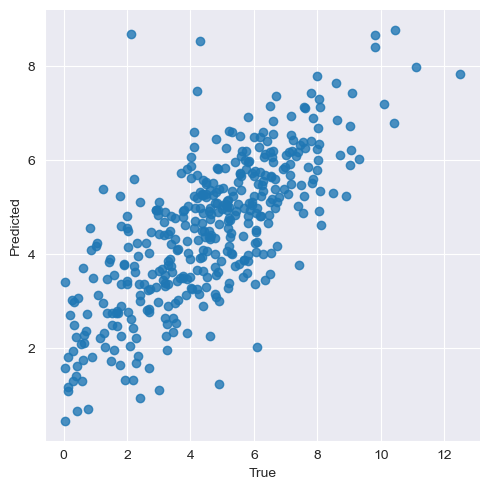

In [103]:

sns.lmplot(test_results_df, x='True', y='Predicted', legend=False, fit_reg=False)